Deep Fake Analyzer: Using CNNs to detect deepfakes

In [1]:
import os
import pandas as pd
import numpy as np
import pandas
from torch.utils.data import Dataset, DataLoader
from skimage import io
import torch
from torchvision import transforms
import torch.nn as nn
from matplotlib import pyplot as plt

In [2]:
os.chdir("/Users/devam/PycharmProjects/DeepFakeAnalyzer/dset")

In [3]:
class Loader(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
        imgpath = os.path.join(self.root_dir, self.annotations.iloc[index,0])
        image = io.imread(imgpath)
        label = torch.tensor(int(self.annotations.iloc[index,1]))
        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
datainstance = Loader(csv_file='/Users/devam/PycharmProjects/DeepFakeAnalyzer/minikey.csv', root_dir='', transform=transforms.ToTensor())

In [5]:
trainingset, testingset = torch.utils.data.random_split(datainstance,[750, 249])

In [6]:
trainingloader = DataLoader(dataset=trainingset, batch_size=75, shuffle=True)
testingloader = DataLoader(dataset=testingset, batch_size=75, shuffle=True)

In [7]:
for x, y in trainingloader:
    print(x)
    break

tensor([[[[0.2431, 0.2588, 0.2706,  ..., 0.2039, 0.2157, 0.2275],
          [0.2392, 0.2510, 0.2588,  ..., 0.2353, 0.2118, 0.1882],
          [0.2314, 0.2392, 0.2431,  ..., 0.2078, 0.1922, 0.1725],
          ...,
          [0.5098, 0.5059, 0.5059,  ..., 0.5059, 0.5333, 0.5137],
          [0.5059, 0.5059, 0.5020,  ..., 0.5529, 0.6039, 0.5686],
          [0.5059, 0.5059, 0.5020,  ..., 0.5608, 0.6275, 0.6078]],

         [[0.2000, 0.2157, 0.2314,  ..., 0.1804, 0.1922, 0.2039],
          [0.2039, 0.2157, 0.2275,  ..., 0.2157, 0.1922, 0.1686],
          [0.2157, 0.2235, 0.2275,  ..., 0.2039, 0.1882, 0.1686],
          ...,
          [0.5765, 0.5765, 0.5765,  ..., 0.6196, 0.6549, 0.6353],
          [0.5725, 0.5725, 0.5725,  ..., 0.6039, 0.6353, 0.6000],
          [0.5725, 0.5725, 0.5725,  ..., 0.5490, 0.5922, 0.5608]],

         [[0.2235, 0.2314, 0.2275,  ..., 0.0941, 0.1059, 0.1176],
          [0.2235, 0.2275, 0.2196,  ..., 0.1373, 0.1137, 0.0902],
          [0.2196, 0.2275, 0.2157,  ..., 0

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__();
        self.l1 = nn.Conv2d(in_channels=3, out_channels= 6, kernel_size=(5,5),stride=3)
        self.r1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=1)
        self.l2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(3,3), stride=1)
        self.r2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(3,3), stride=1)
        self.lin1 = nn.Linear(192,100)
        self.lin2 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.l1(x)
        x = self.r1(x)
        x = self.maxpool1(x)
        x = self.l2(x)
        x = self.r2(x)
        x = self.maxpool2(x)
        x = x.flatten(1)
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.sigmoid(x)
        return x

In [9]:
model = Net()

In [10]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [11]:
def train (epochs):
    TL = []
    TA = []
    VA = []

    for epoch in range(epochs):
        for x, y in trainingloader:
            x = torch.from_numpy(np.asarray(x)).float()
            y = torch.from_numpy(np.asarray(y)).float()
            yhat = model(x)
            loss = criterion(yhat.max(dim=1)[0],y)
            print(loss)
            TL.append(loss.data.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        correct = 0
        total = 0

        for x,y in testingloader:
            x = torch.from_numpy(np.asarray(x)).float()
            y = torch.from_numpy(np.asarray(y)).float()
            yhat = model(x)

            real = torch.tensor([1])
            fake = torch.tensor([0])

            labeltranslation = torch.tensor([])

            for hat in yhat:
                if hat < 0.5:
                    labeltranslation = torch.cat((labeltranslation,fake), 0)
                else:
                    labeltranslation = torch.cat((labeltranslation,real), 0)

            correct += (labeltranslation == y).sum().item()
            total += len(y)
            accuracy = 100 * (correct/total)
            VA.append(accuracy)
            print(accuracy)

            break

    return TL, VA

In [12]:
trainingdata = train(75)

tensor(0.6925, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6939, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6924, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6927, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6930, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6917, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6925, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6930, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6922, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6913, grad_fn=<BinaryCrossEntropyBackward0>)
45.33333333333333
tensor(0.6905, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6910, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6907, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6903, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6910, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6917, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6906, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6933, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6

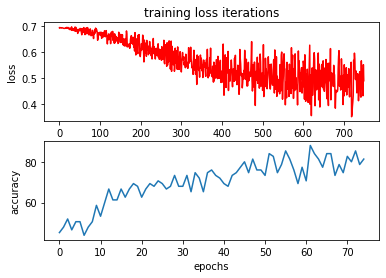

In [13]:
plt.subplot(2, 1, 1)
plt.plot(trainingdata[0], 'r')
plt.ylabel('loss')
plt.title('training loss iterations')
plt.subplot(2, 1, 2)
plt.plot(trainingdata[1])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()